# CLASSIFICATORE SVC

In questo notebook, ci occuperemo di costruire un classificatore a vettori supporto per tutti e tre i Monk's problem. Iniziamo importando le librerie e le classi che ci serviranno nei diversi momenti della nostra costruzione.  

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, hinge_loss, classification_report

Dal momento che tutti e tre i problemi sono molto simili, creiamo un'unica funzione prepocessing () che tratti i dati prima di utilizzarli per l'addestramento. 
Questa funzione prende in input l'indice del problema (1, 2 o 3) e restituisce i dati di train e di test con le loro etichette in quattro oggetti diversi. 
X_train contiene i dati del trainset, le cui feature sono state standardizzate attraverso uno StandardScaler(). La standardizzazione permette di rendere l'algoritmo meno sensibile agli outliers, e inoltre fa in modo che le feature abbiano media pari a zero e varianza unitaria, cosa che dovrebbe facilitare l'apprendimento dei parametri. Chiaramente, dopo aver fatto il fit sui dati di train, standardizziamo anche i dati del testset indicati con l'oggetto X_test.
y_train, invece, è l'array delle label dei dati di test. È importante notare che le label in questo array devono avere lo stesso indice dell'osservazione contenuta nell'array X_train cui si riferiscono. La stessa premura vale per la lista test_labels, che non viene convertita in array perchè non ce n'è bisogno. 
Dopo aver definito la nostra funziona preprocessing(), la chiamiamo per ottenere il trainset e il testset completi per ognuno dei tre problemi.

In [15]:
def preprocessing(idx_problem):
    train_path = f"monk+s+problems\\monks-{idx_problem}.train"
    test_path = f"monk+s+problems\\monks-{idx_problem}.test"

    train_features, train_labels = [], []
    test_features, test_labels = [], []
    
    scaler = StandardScaler()
    
    for line in open(train_path):
        line = line.split()
        train_features.append([int(el) for el in line[1:7]])
        train_labels.append(line[0])

    for line in open(test_path):
        line = line.split()
        test_features.append([int(el) for el in line[1:7]])
        test_labels.append(line[0])
        
    X_train = scaler.fit_transform(train_features)
    y_train = np.asarray(train_labels)
    
    X_test = scaler.transform(test_features)      
    
    return (X_train, y_train,
            X_test, test_labels)

In [16]:
#trainset e testset per il primo monk's problem
X_train_1, y_train_1, X_test_1, test_labels_1= preprocessing(1)

#trainset e testset per il secondo monk's problem
X_train_2, y_train_2, X_test_2, test_labels_2 = preprocessing(2)

#trainset e testset per il terzo monk's problem
X_train_3, y_train_3, X_test_3, test_labels_3 = preprocessing(3)

Ora che abbiamo ottenuto tutti i dati necessari per tutti e tre i problemi, non ci resta che addestrare il classificatore a vettori supporto per ciascuno di essi.
Per trovare gli iperparametri migliori eseguiamo una gridsearch sul solo trainset. Inoltre, optiamo per una leave-one-out cross-validation per confrontare le varie combinazioni di iperparametri. La leave-one-out cross-validation (d'ora in poi: loocv) è una tecnica estrema di kfold cross-validation che consiste nel creare tanti fold quanti sono i dati del trainset, addestrare il modello su tutti i fold tranne uno, e validarlo sull'unica osservazione estromessa. Si tratta di un metodo computazionalmente costoso, ma che, vista la dimensione ridotta del nostro trainset, può rivelarsi molto più utile di una normale cross-validation: infatti, dati i pochi dati in input, i risultati che otteniamo sono molto vicini a quelli che otterremmo addestrando il modello sulla totalità dei dati, e il basso numero di dati rende il tempo di esecuzione meno proibitivo.

Per prima cosa fissiamo i parametri della gridsearch:

Successivamente creiamo la funzione gridsearch_with_loocv() che prende in input i parametri definiti sopra e i dati del trainset su cui vogliamo effettuare la gridsearch. La funzione trova la miglior combinazione di iperparametri tra i parametri che abbiamo definito, e li stampa a schermo. Inoltre, restituisce in output il modello con quella combinazione, in modo così da poter subito proseguire con il train sull'intero trainset nel caso in cui i risultati ci soddisfino

In [17]:
def gridsearch_with_loocv(estimator, X_train, y_train, param_grid, scoring={'accuracy': 'accuracy'}):
    
    n_splits = len(X_train)
    loocv = KFold(n_splits=n_splits)
    
    gs = GridSearchCV(estimator=estimator,
                      param_grid=param_grid,
                      scoring=scoring,
                      cv=loocv,
                      refit='accuracy',
                      n_jobs=-1)
    
    if 'hinge_loss' in scoring.keys():
        lb = LabelBinarizer(pos_label=1, neg_label=-1)
        y_train = lb.fit_transform(y_train).ravel()        
           
    gs.fit(X_train, y_train)
    
    return gs

Inoltre, creiamo una funzione che si occupi della visualizzazione (tramite heatmap) dei risultati della grid search sia per l'accuracy, sia per la hinge loss

In [18]:
def visualize_results(gs, param_grid):
    
    results = pd.DataFrame(gs.cv_results_)
    
    C_values = param_grid['C']
    gamma_values = param_grid['gamma']
    
    accuracy_gs = np.array(results['mean_test_accuracy']).reshape(len(C_values), len(gamma_values))
    hinge_loss_gs = -np.array(results['mean_test_hinge_loss']).reshape(len(C_values), len(gamma_values))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(accuracy_gs, annot=True, fmt='.3f', xticklabels=gamma_values, yticklabels=C_values, cmap="viridis")
    plt.title("Accuracy Heatmap")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(hinge_loss_gs, annot=True, fmt='.3f', xticklabels=gamma_values, yticklabels=C_values, cmap="magma")
    plt.title("Hinge Loss Heatmap")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    
    plt.tight_layout()
    plt.show()

A questo punto non resta che eseguire la gridsearch per tutti e tre i problemi. 
#

### Monk's problem 1
Iniziamo con il primo problema. Dopo aver effettuato la gridsearch, plottiamo i risultati in una heatmap per avere una visione intuitiva della variazione delle performance rispetto alla variazione degli iperparametri scelti. 

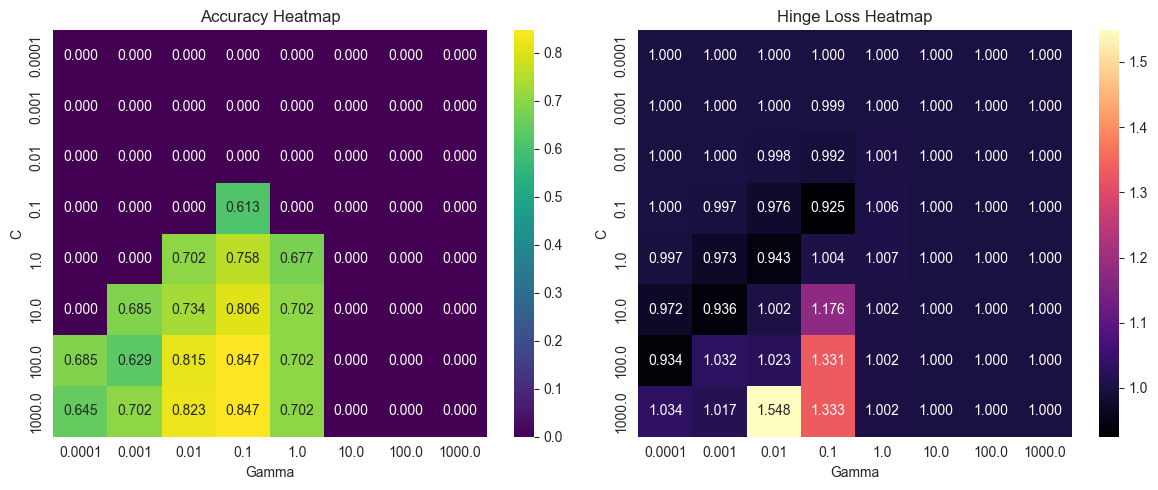

In [19]:
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_grid = {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}

scoring_svc = {
        'accuracy': 'accuracy',
        'hinge_loss': make_scorer(hinge_loss, greater_is_better=False, response_method='decision_function')
}

GS_MONK1 = gridsearch_with_loocv(SVC(random_state=1), X_train_1, y_train_1, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK1, param_grid)

Esploriamo la sezione che ha portato i risultati più interessanti

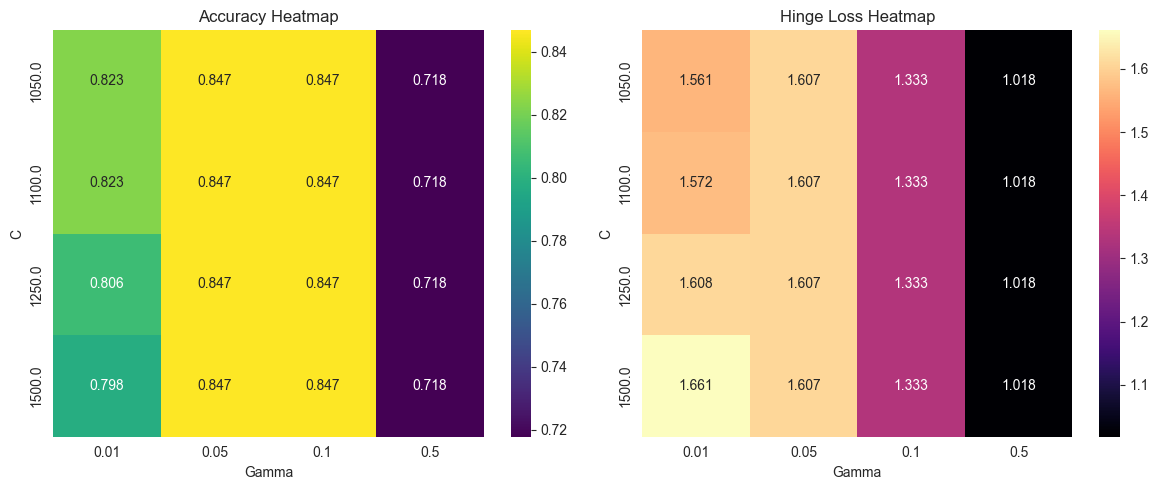

In [20]:
param_range_C = [1050.0, 1100.0, 1250.0, 1500.0]
param_range_gamma = [0.01, 0.05, 0.1, 0.5]

param_grid = {'C': param_range_C,
               'gamma': param_range_gamma,
               'kernel': ['rbf']}

GS_MONK1 = gridsearch_with_loocv(SVC(random_state=1), X_train_1, y_train_1, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK1, param_grid)

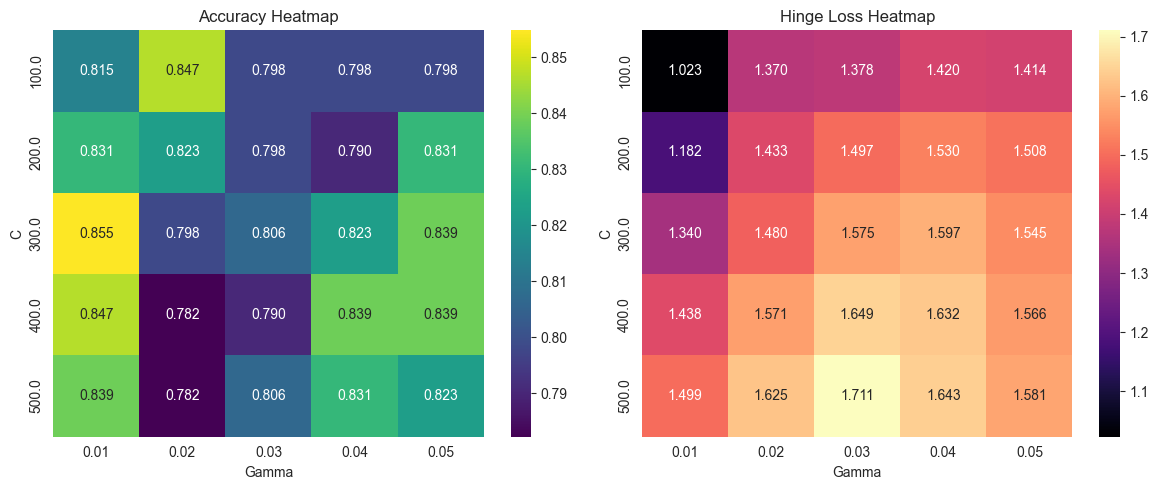

In [21]:
param_range_C = [100.0, 200.0, 300.0, 400.0, 500.0]
param_range_gamma = [0.01, 0.02, 0.03, 0.04, 0.05]

param_grid = {'C': param_range_C,
               'gamma': param_range_gamma,
               'kernel': ['rbf']}

GS_MONK1 = gridsearch_with_loocv(SVC(random_state=1), X_train_1, y_train_1, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK1, param_grid)

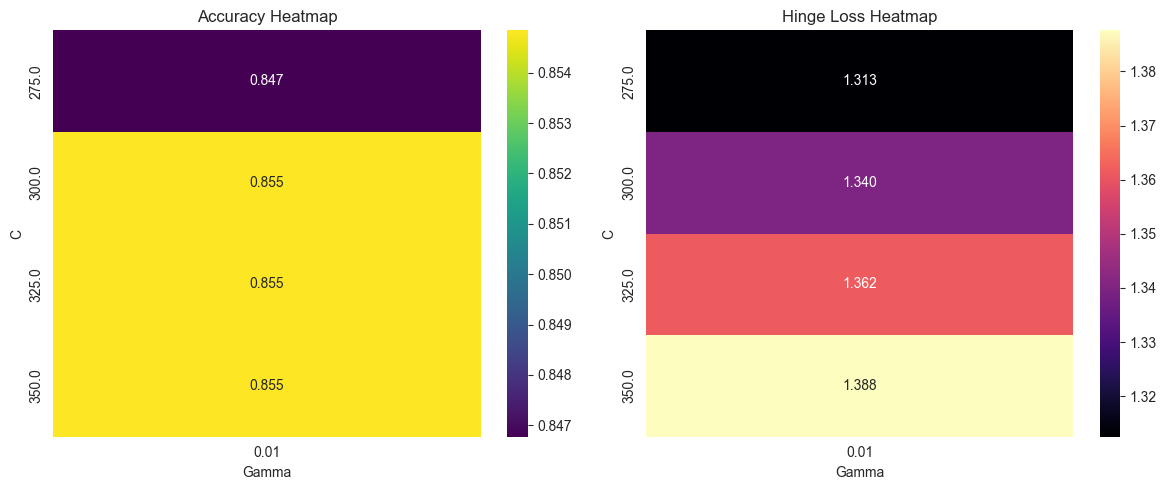

In [22]:
param_range_C = [275.0, 300.0, 325.0, 350.0]

param_grid = {'C': param_range_C,
               'gamma': [0.01],
               'kernel': ['rbf']}

GS_MONK1 = gridsearch_with_loocv(SVC(random_state=1), X_train_1, y_train_1, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK1, param_grid)

Ora che abbiamo trovato la miglior combinazione di iperparametri tra quelli dati in input, possiamo addestrare il modello così trovato sulla totalità del trainset e testarlo sul testset

In [23]:
SVC_MONK1 = SVC(random_state=1, kernel='rbf', C=275.0, gamma=0.01)

SVC_MONK1.fit(X_train_1, y_train_1)

test_predictions_1 = SVC_MONK1.predict(X_test_1)

results_1 = classification_report(test_labels_1, test_predictions_1, zero_division=0)
print(results_1)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       216
           1       0.82      0.84      0.83       216

    accuracy                           0.83       432
   macro avg       0.83      0.83      0.83       432
weighted avg       0.83      0.83      0.83       432


### Monk’s problem 2
Passiamo ora al secondo problema. La maggior differenza rispetto al primo è che poniamo subito l'opzione weight = 'balanced'. A questo punto, tentiamo la grid search con gli stessi intervalli inizializzati per il primo problema

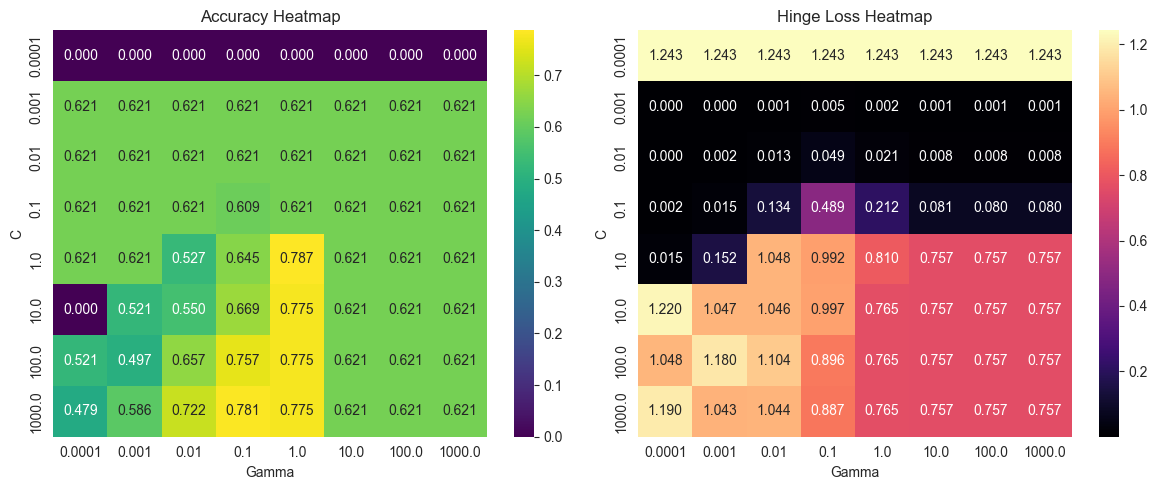

In [24]:
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_grid = {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}

scoring_svc = {
        'accuracy': 'accuracy',
        'hinge_loss': make_scorer(hinge_loss, greater_is_better=False, response_method='decision_function')
}

GS_MONK2 = gridsearch_with_loocv(SVC(random_state=1, class_weight='balanced'), X_train_2, y_train_2, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK2, param_grid)

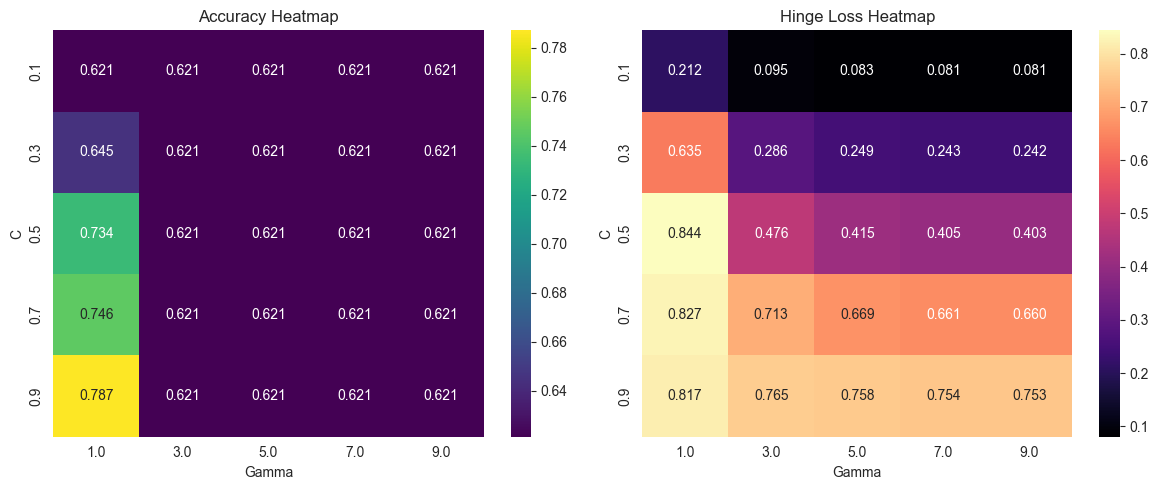

In [25]:
param_range_C = [0.1, 0.3, 0.5, 0.7, 0.9]
param_range_gamma = [1.0, 3.0, 5.0, 7.0, 9.0]

param_grid = {'C': param_range_C,
               'gamma': param_range_gamma,
               'kernel': ['rbf']}

GS_MONK2 = gridsearch_with_loocv(SVC(random_state=1, class_weight='balanced'), X_train_2, y_train_2, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK2, param_grid)

In [30]:
SVC_MONK2 = SVC(random_state=1, kernel='rbf',  class_weight='balanced', C=1.0, gamma=1.0)

SVC_MONK2.fit(X_train_2, y_train_2)

test_predictions_2 = SVC_MONK2.predict(X_test_2)

results_2 = classification_report(test_labels_2, test_predictions_2, zero_division=0)
print(results_2)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       290
           1       0.79      0.77      0.78       142

    accuracy                           0.86       432
   macro avg       0.84      0.83      0.84       432
weighted avg       0.86      0.86      0.86       432


### Monk’s problem 3
Finiamo con il terzo problema. Non dobbiamo porre nessuna opzione. Tentiamo la grid search con gli stessi intervalli inizializzati per il primo problema

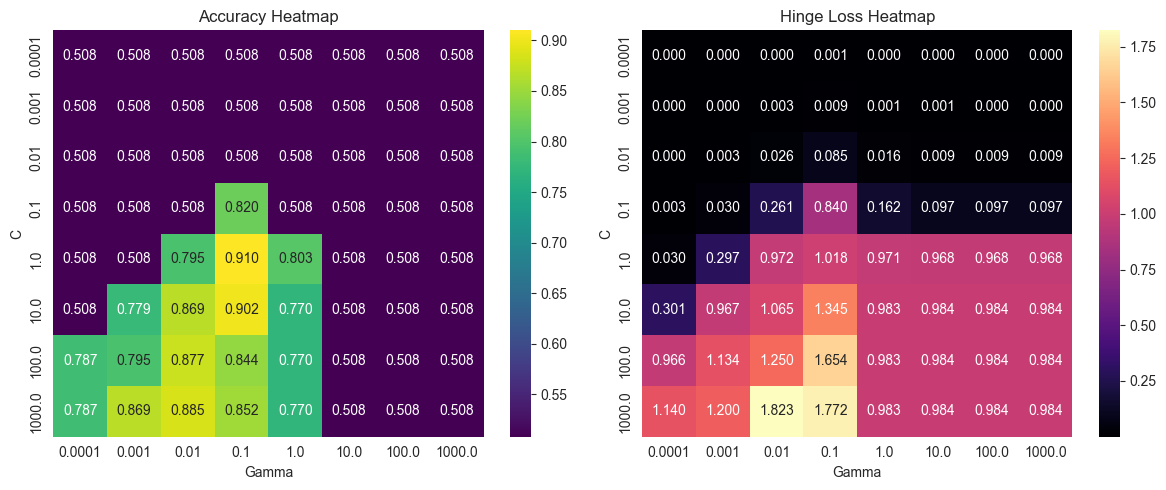

In [32]:
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_grid = {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}

scoring_svc = {
        'accuracy': 'accuracy',
        'hinge_loss': make_scorer(hinge_loss, greater_is_better=False, response_method='decision_function')
}

GS_MONK3 = gridsearch_with_loocv(SVC(random_state=1), X_train_3, y_train_3, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK3, param_grid)

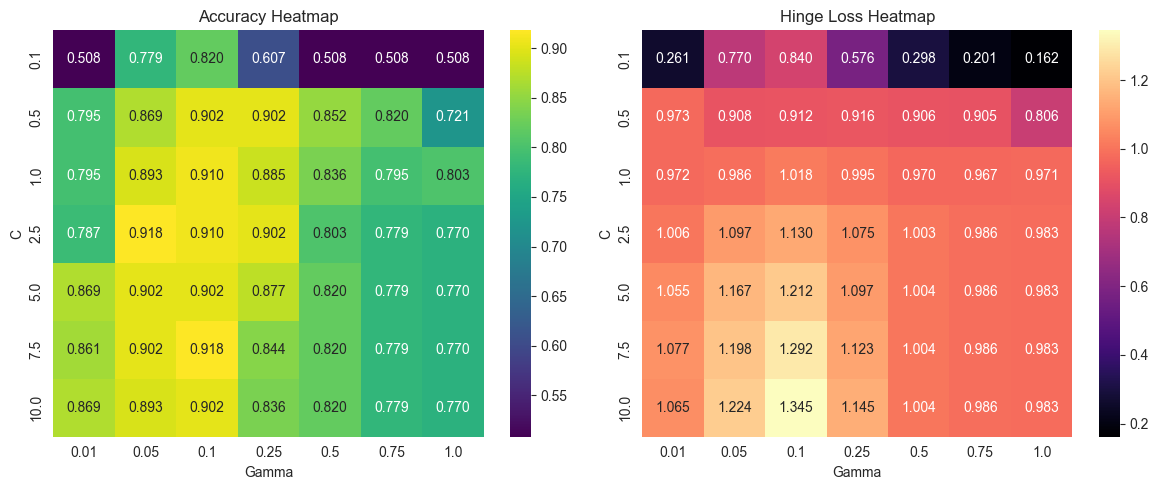

In [33]:
param_range_C = [0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0]
param_range_gamma = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

param_grid = {'C': param_range_C,
               'gamma': param_range_gamma,
               'kernel': ['rbf']}

GS_MONK3 = gridsearch_with_loocv(SVC(random_state=1), X_train_3, y_train_3, param_grid, scoring=scoring_svc)
visualize_results(GS_MONK3, param_grid)

In [34]:
SVC_MONK3 = SVC(random_state=1, kernel='rbf', C=2.5, gamma=0.05)

SVC_MONK3.fit(X_train_3, y_train_3)

test_predictions_3 = SVC_MONK3.predict(X_test_3)

results_3 = classification_report(test_labels_3, test_predictions_3, zero_division=0)
print(results_3)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       204
           1       1.00      0.89      0.94       228

    accuracy                           0.94       432
   macro avg       0.95      0.95      0.94       432
weighted avg       0.95      0.94      0.94       432
